## 1. Import Libraries

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision
from torchvision import transforms, models
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from tqdm.auto import tqdm
# Set the GPU device
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 3090


## 2. Configuration

In [ ]:
# Dataset configuration
DATA_DIR = os.path.expanduser('~/ML_Project/HuSHem')
IMG_SIZE = 128  # Increased from 70 to 128 for better resolution
BATCH_SIZE = 32  # As specified in Table S1 for HuSHeM
NUM_CLASSES = 4
CLASS_NAMES = ['Normal', 'Tapered', 'Pyriform', 'Amorphous']

# Training configuration (HuSHeM defaults from Table S1)
NUM_EPOCHS = 100
# Default LR for HuSHeM base models (per-table values). Kept as dict to allow per-model overrides.
LEARNING_RATE = 1e-4
MODEL_LR = {
    'vgg16': 1e-4,
    'vgg19': 1e-4,
    'resnet34': 1e-4,
    'densenet161': 1e-4
}
WEIGHT_DECAY = 1e-4
PATIENCE = 15  # Early stopping patience

# Cross-validation: 3x repeated 5-fold CV as per paper
N_SPLITS = 5
N_REPEATS = 3

# ImageNet normalization stats
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Output directory
OUTPUT_DIR = os.path.join(DATA_DIR, 'outputs')
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Data Loading and Preprocessing

In [13]:
def load_dataset_paths():
    """Load all image paths and labels from the dataset directory."""
    image_paths = []
    labels = []
    
    class_dirs = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
    
    for class_idx, class_dir in enumerate(class_dirs):
        class_path = os.path.join(DATA_DIR, class_dir)
        images = [f for f in os.listdir(class_path) if f.endswith('.BMP')]
        
        for img_name in images:
            image_paths.append(os.path.join(class_path, img_name))
            labels.append(class_idx)
    
    return np.array(image_paths), np.array(labels)

# Load dataset
image_paths, labels = load_dataset_paths()
print(f"Total images: {len(image_paths)}")
print(f"Label distribution: {np.bincount(labels)}")
print(f"Classes: {CLASS_NAMES}")

Total images: 216
Label distribution: [54 53 57 52]
Classes: ['Normal', 'Tapered', 'Pyriform', 'Amorphous']


In [ ]:
import json

# Load manual annotations (if available)
ANNOTATION_FILE = os.path.join(DATA_DIR, 'head_orientation_annotations.json')
if os.path.exists(ANNOTATION_FILE):
    with open(ANNOTATION_FILE, 'r') as f:
        head_orientation_annotations = json.load(f)
    print(f"✓ Loaded {len(head_orientation_annotations)} manual annotations")
else:
    head_orientation_annotations = {}
    print("⚠ No manual annotations found. Using automatic PCA-based alignment (may be inaccurate).")


def align_to_left(pil_img, img_rel_path=None):
    """Align image so the sperm head points to the left.
    
    If manual annotation exists for this image, use it directly.
    Otherwise fall back to automatic PCA-based alignment (may be inaccurate).
    
    Args:
        pil_img: PIL Image (can be 131x131 or 70x70 after crop)
        img_rel_path: Relative path like '01_Normal/image_001.BMP' for looking up annotation
    
    Returns:
        PIL Image rotated so head points left
    """
    # If we have manual annotation, use it directly (100% accurate)
    if img_rel_path and img_rel_path in head_orientation_annotations:
        rotation_angle = head_orientation_annotations[img_rel_path]
        if rotation_angle != 0:
            # Use expand=False to keep 131x131 size (center will be maintained for center crop)
            return pil_img.rotate(rotation_angle, resample=Image.BICUBIC, expand=False)
        return pil_img
    
    # Fall back to automatic alignment (not 100% accurate)
    try:
        import numpy as _np
        
        img_gray = pil_img.convert('L')
        arr = _np.array(img_gray).astype(_np.float32)
        h, w = arr.shape
        
        # Invert: make sperm bright on dark background
        arr_inv = 255 - arr
        
        # Threshold to get mask
        thresh = _np.percentile(arr_inv, 70)
        mask = arr_inv > thresh
        
        if _np.sum(mask) < 50:
            return pil_img
            
        # Get coordinates of mask pixels
        ys, xs = _np.where(mask)
        if len(xs) < 20:
            return pil_img
            
        # Compute PCA
        coords = _np.vstack([xs, ys]).astype(_np.float32)
        coords_centered = coords - coords.mean(axis=1, keepdims=True)
        cov = _np.cov(coords_centered)
        eigvals, eigvecs = _np.linalg.eig(cov)
        
        idx = _np.argmax(eigvals)
        principal_vec = eigvecs[:, idx].real
        
        angle_rad = _np.arctan2(principal_vec[1], principal_vec[0])
        angle_deg = _np.degrees(angle_rad)
        
        rotation_angle = -angle_deg
        img_rotated = pil_img.rotate(rotation_angle, resample=Image.BICUBIC, expand=False)
        
        # Determine which end is the head using weighted centroid
        arr_rot = _np.array(img_rotated.convert('L')).astype(_np.float32)
        arr_rot_inv = 255 - arr_rot
        mask_rot = arr_rot_inv > thresh
        
        if _np.sum(mask_rot) < 50:
            return img_rotated
            
        ys_rot, xs_rot = _np.where(mask_rot)
        weights = arr_rot_inv[mask_rot]
        
        weighted_x = _np.average(xs_rot, weights=weights)
        
        # If weighted centroid is on the right half, flip 180
        if weighted_x > w / 2:
            img_rotated = img_rotated.rotate(180, resample=Image.BICUBIC)
            
        return img_rotated
        
    except Exception as e:
        return pil_img


class SpermDataset(Dataset):
    """Custom Dataset for Sperm Head Images."""

    def __init__(self, image_paths, labels, transform=None, align=True):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.align = align

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        # Alignment: rotate so the main axis points to the left (face-left)
        if self.align:
            try:
                # Get relative path for annotation lookup
                rel_path = os.path.relpath(img_path, DATA_DIR)
                image = align_to_left(image, rel_path)
            except Exception:
                pass
        
        # Resize AFTER rotation to preserve all sperm content
        image = transforms.Resize((128, 128))(image)
        
        label = self.labels[idx]

        if self.transform:

            image = self.transform(image)

        return image, label

✓ Loaded 216 manual annotations


In [ ]:
# Data augmentation transforms (only vertical flipping as per paper)
# ORDER: Rotate → Resize(128×128) → Augment → Normalize
# Resize is done in Dataset __getitem__ AFTER rotation to preserve all content
train_transform = transforms.Compose([
    transforms.RandomVerticalFlip(p=0.5),  # Only vertical flipping as per paper
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

## 4. Visualize Sample Images

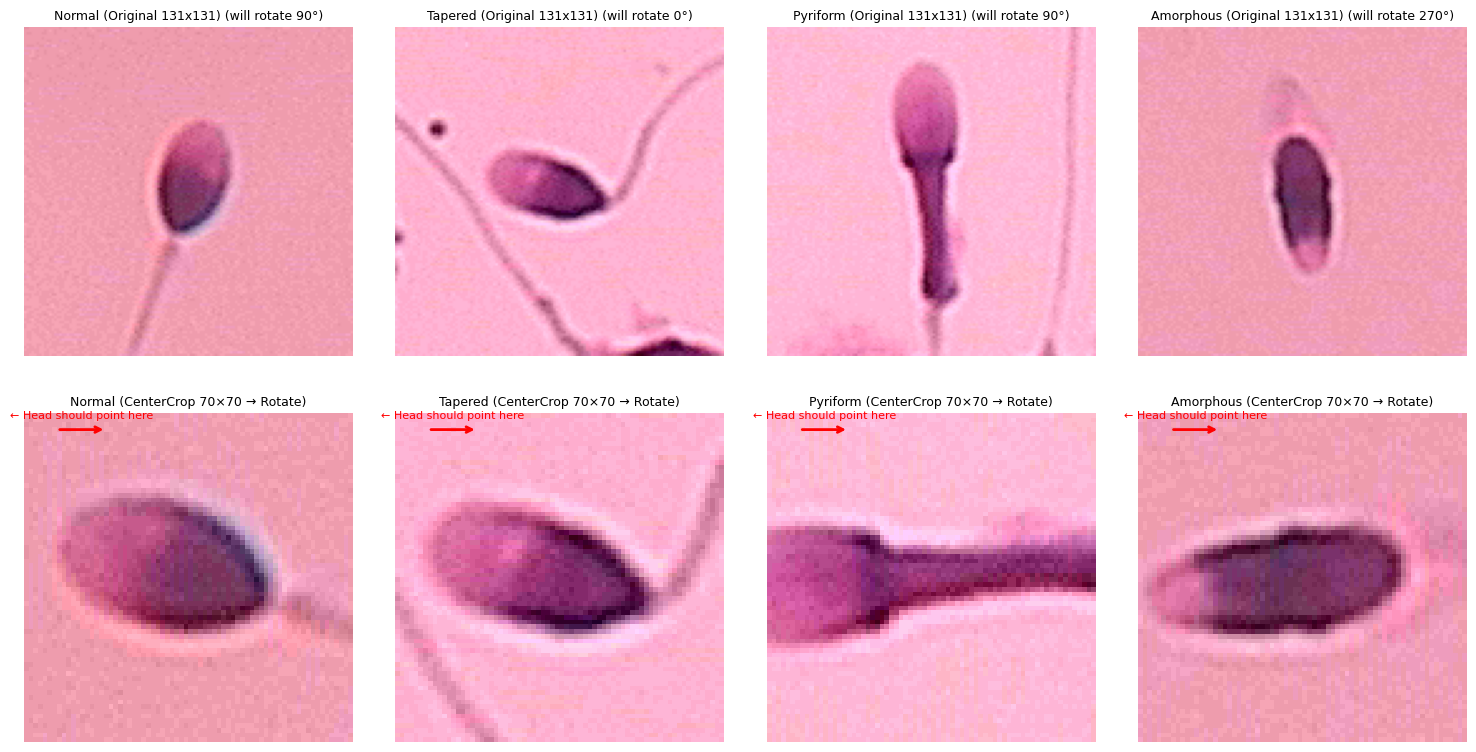


Annotation Status:
  Total images: 216
  Annotated: 216
  Rotation distribution:
    0°: 53 images
    90°: 68 images
    180°: 40 images
    270°: 55 images


In [ ]:
# Visualize some sample images with proper preprocessing pipeline
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(4):
    # Get first image from each class
    class_indices = np.where(labels == i)[0]
    img_path = image_paths[class_indices[0]]
    img = Image.open(img_path).convert('RGB')
    rel_path = os.path.relpath(img_path, DATA_DIR)
    
    # Original
    axes[i].imshow(img)
    # Show rotation info if annotated
    rotation_info = ""
    if rel_path in head_orientation_annotations:
        rotation_info = f" (will rotate {head_orientation_annotations[rel_path]}°)"
    axes[i].set_title(f'{CLASS_NAMES[i]} (Original 131x131){rotation_info}', fontsize=9)
    axes[i].axis('off')
    
    # Preprocessed: Rotate → Resize 128×128 → Normalize
    # Step 1: Rotate to align
    img_aligned = align_to_left(img, rel_path)
    # Step 2: Resize to 128×128
    img_resized = transforms.Resize((128, 128))(img_aligned)
    # Step 3: Apply normalize transform
    img_processed = val_transform(img_resized)
    
    # Denormalize for visualization
    img_display = img_processed.permute(1, 2, 0).numpy()
    img_display = img_display * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img_display = np.clip(img_display, 0, 1)
    
    # Display processed image
    axes[i+4].imshow(img_display)
    axes[i+4].set_title(f'{CLASS_NAMES[i]} (Rotate → Resize 128×128)', fontsize=9)
    axes[i+4].axis('off')
    
    # Draw reference arrow on aligned image
    axes[i+4].annotate('', xy=(0.25, 0.95), xytext=(0.1, 0.95),
                      xycoords='axes fraction',
                      arrowprops=dict(arrowstyle='->', lw=2, color='red'))
    axes[i+4].text(0.175, 0.98, '← Head should point here', 
                  transform=axes[i+4].transAxes,
                  fontsize=8, color='red', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sample_images.png'), dpi=150, bbox_inches='tight')
plt.show()

# Show annotation stats
print(f"\nAnnotation Status:")
print(f"  Total images: {len(image_paths)}")
print(f"  Annotated: {len(head_orientation_annotations)}")
if len(head_orientation_annotations) > 0:
    from collections import Counter
    rotation_counts = Counter(head_orientation_annotations.values())
    print(f"  Rotation distribution:")
    for rot in sorted(rotation_counts.keys()):

        print(f"    {rot}°: {rotation_counts[rot]} images")

## 5. Model Definitions

In [17]:
def get_model(model_name, num_classes=4, pretrained=True):
    """Get pre-trained model with custom classifier.

    Args:
        model_name: One of ['vgg16', 'vgg19', 'resnet34', 'densenet161']
        num_classes: Number of output classes
        pretrained: Use ImageNet pre-trained weights
    """

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=pretrained)
        # Ensure a fixed pooling output for our classifier by using AdaptiveAvgPool
        model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        num_features = 512 * 7 * 7
        # classifier per Table S1: 4096 -> dropout(0.4) -> 1000 -> dropout(0.4) -> output
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1000, num_classes)
        )

    elif model_name == 'vgg19':
        model = models.vgg19(pretrained=pretrained)
        model.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        num_features = 512 * 7 * 7
        model.classifier = nn.Sequential(
            nn.Linear(num_features, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1000, num_classes)
        )

    elif model_name == 'resnet34':
        # Modified ResNet-34: remove final conv block (layer4) as per paper
        model = models.resnet34(pretrained=pretrained)
        # remove layer4 by replacing with identity
        model.layer4 = nn.Identity()
        # after layer3 output channels == 256
        model.fc = nn.Linear(256, num_classes)

    elif model_name == 'densenet161':
        model = models.densenet161(pretrained=pretrained)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)

    else:
        raise ValueError(f"Unknown model: {model_name}")

    return model

# Test model creation
# for model_name in ['vgg16', 'vgg19', 'resnet34', 'densenet161']:
#     model = get_model(model_name, num_classes=NUM_CLASSES)
#     print(f"{model_name}: {sum(p.numel() for p in model.parameters())} parameters")

## 6. Training Functions

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc, np.array(all_preds), np.array(all_labels)


def get_weighted_sampler(labels):
    """Create weighted random sampler for imbalanced data."""
    class_counts = np.bincount(labels)
    class_weights = 1. / class_counts
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    return sampler

In [19]:
def train_model_kfold(model_name, train_idx, val_idx, fold_num, repeat_num):
    """Train a model on one fold of the cross-validation."""

    # Create datasets
    train_paths = image_paths[train_idx]
    train_labels = labels[train_idx]
    val_paths = image_paths[val_idx]
    val_labels = labels[val_idx]

    train_dataset = SpermDataset(train_paths, train_labels, transform=train_transform, align=True)
    val_dataset = SpermDataset(val_paths, val_labels, transform=val_transform, align=True)

    # Create weighted sampler for training
    train_sampler = get_weighted_sampler(train_labels)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                            sampler=train_sampler, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                          shuffle=False, num_workers=4)

    # Initialize model
    model = get_model(model_name, num_classes=NUM_CLASSES, pretrained=True)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    lr = MODEL_LR.get(model_name, LEARNING_RATE)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                     factor=0.5, patience=5, verbose=False)

    # Training loop
    best_val_acc = 0.0
    patience_counter = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, val_preds, val_true = validate_epoch(model, val_loader, criterion, device)
        
        scheduler.step(val_loss)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # Save best model
            best_model_state = model.state_dict().copy()
            best_preds = val_preds
            best_true = val_true
        else:
            patience_counter += 1
        
        if patience_counter >= PATIENCE:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Calculate metrics
    f1 = f1_score(best_true, best_preds, average='macro')
    
    results = {
        'model_name': model_name,
        'repeat': repeat_num,
        'fold': fold_num,
        'best_val_acc': best_val_acc,
        'f1_score': f1,
        'history': history,
        'predictions': best_preds,
        'true_labels': best_true,
        'model_state': best_model_state
    }
    
    return results

## 7. Train Individual Models with Cross-Validation

In [20]:
# Dictionary to store all results
all_results = {}

# Models to train
model_names = ['vgg16', 'vgg19', 'resnet34', 'densenet161']

# 3x repeated 5-fold cross-validation
rskf = RepeatedStratifiedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=SEED)

for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*80}")
    
    model_results = []
    
    fold_num = 0
    for repeat_num in range(N_REPEATS):
        print(f"\nRepeat {repeat_num + 1}/{N_REPEATS}")
        
        skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED + repeat_num)
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
            print(f"  Fold {fold + 1}/{N_SPLITS} - Train: {len(train_idx)}, Val: {len(val_idx)}")
            
            results = train_model_kfold(model_name, train_idx, val_idx, fold + 1, repeat_num + 1)
            model_results.append(results)
            
            print(f"    Best Val Acc: {results['best_val_acc']:.2f}% | F1: {results['f1_score']:.4f}")
            fold_num += 1
    
    all_results[model_name] = model_results
    
    # Print summary for this model
    accuracies = [r['best_val_acc'] for r in model_results]
    f1_scores = [r['f1_score'] for r in model_results]
    
    print(f"\n{model_name.upper()} Summary:")
    print(f"  Mean Accuracy: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
    print(f"  Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    
print("\n" + "="*80)
print("Training completed for all models!")
print("="*80)


Training VGG16

Repeat 1/3
  Fold 1/5 - Train: 172, Val: 44


  Early stopping at epoch 35
    Best Val Acc: 100.00% | F1: 1.0000
  Fold 2/5 - Train: 173, Val: 43
  Early stopping at epoch 28
    Best Val Acc: 90.70% | F1: 0.9069
  Fold 3/5 - Train: 173, Val: 43
  Early stopping at epoch 28
    Best Val Acc: 90.70% | F1: 0.9069
  Fold 3/5 - Train: 173, Val: 43
  Early stopping at epoch 32
    Best Val Acc: 100.00% | F1: 1.0000
  Fold 4/5 - Train: 173, Val: 43
  Early stopping at epoch 32
    Best Val Acc: 100.00% | F1: 1.0000
  Fold 4/5 - Train: 173, Val: 43
  Early stopping at epoch 30
    Best Val Acc: 93.02% | F1: 0.9278
  Fold 5/5 - Train: 173, Val: 43
  Early stopping at epoch 30
    Best Val Acc: 93.02% | F1: 0.9278
  Fold 5/5 - Train: 173, Val: 43
  Early stopping at epoch 19
    Best Val Acc: 90.70% | F1: 0.9068

Repeat 2/3
  Fold 1/5 - Train: 172, Val: 44
  Early stopping at epoch 19
    Best Val Acc: 90.70% | F1: 0.9068

Repeat 2/3
  Fold 1/5 - Train: 172, Val: 44
  Early stopping at epoch 23
    Best Val Acc: 95.45% | F1: 0.9545
  Fold

## 8. Results Comparison

In [21]:
# Create summary dataframe
summary_data = []

for model_name, results_list in all_results.items():
    accuracies = [r['best_val_acc'] for r in results_list]
    f1_scores = [r['f1_score'] for r in results_list]
    
    summary_data.append({
        'Model': model_name.upper(),
        'Mean Accuracy (%)': f"{np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}",
        'Mean F1 Score': f"{np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}",
        'Min Accuracy (%)': f"{np.min(accuracies):.2f}",
        'Max Accuracy (%)': f"{np.max(accuracies):.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(summary_df.to_string(index=False))
print("\n")

# Save to CSV
summary_df.to_csv(os.path.join(OUTPUT_DIR, 'model_comparison_summary.csv'), index=False)
print(f"Summary saved to: {os.path.join(OUTPUT_DIR, 'model_comparison_summary.csv')}")


MODEL COMPARISON SUMMARY
      Model Mean Accuracy (%)   Mean F1 Score Min Accuracy (%) Max Accuracy (%)
      VGG16      93.97 ± 3.97 0.9396 ± 0.0390            86.05           100.00
      VGG19      92.89 ± 4.77 0.9277 ± 0.0482            86.05           100.00
   RESNET34      92.12 ± 3.88 0.9211 ± 0.0391            83.72           100.00
DENSENET161      90.43 ± 3.58 0.9046 ± 0.0352            83.72            95.45


Summary saved to: /home/23giang.ns/ML_Project/HuSHem/outputs/model_comparison_summary.csv


## 9. Visualize Results

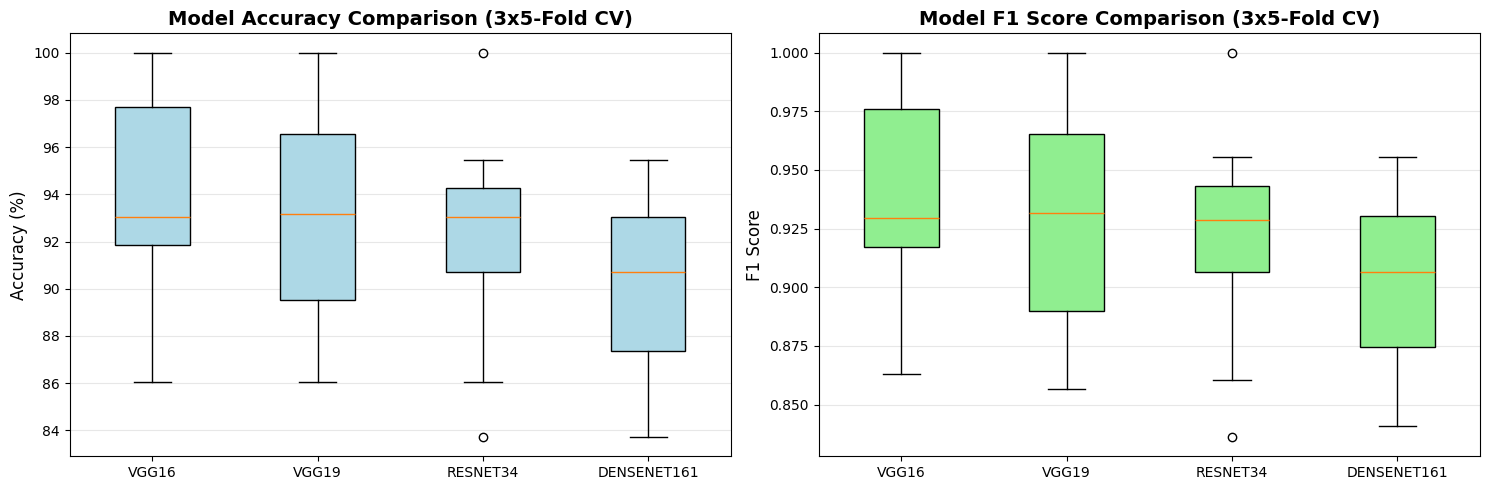

In [22]:
# Boxplot comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy comparison
acc_data = [[r['best_val_acc'] for r in all_results[m]] for m in model_names]
bp1 = axes[0].boxplot(acc_data, labels=[m.upper() for m in model_names], patch_artist=True)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Model Accuracy Comparison (3x5-Fold CV)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')

# F1 Score comparison
f1_data = [[r['f1_score'] for r in all_results[m]] for m in model_names]
bp2 = axes[1].boxplot(f1_data, labels=[m.upper() for m in model_names], patch_artist=True)
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Model F1 Score Comparison (3x5-Fold CV)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for patch in bp2['boxes']:
    patch.set_facecolor('lightgreen')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison_boxplot.png'), dpi=150, bbox_inches='tight')
plt.show()

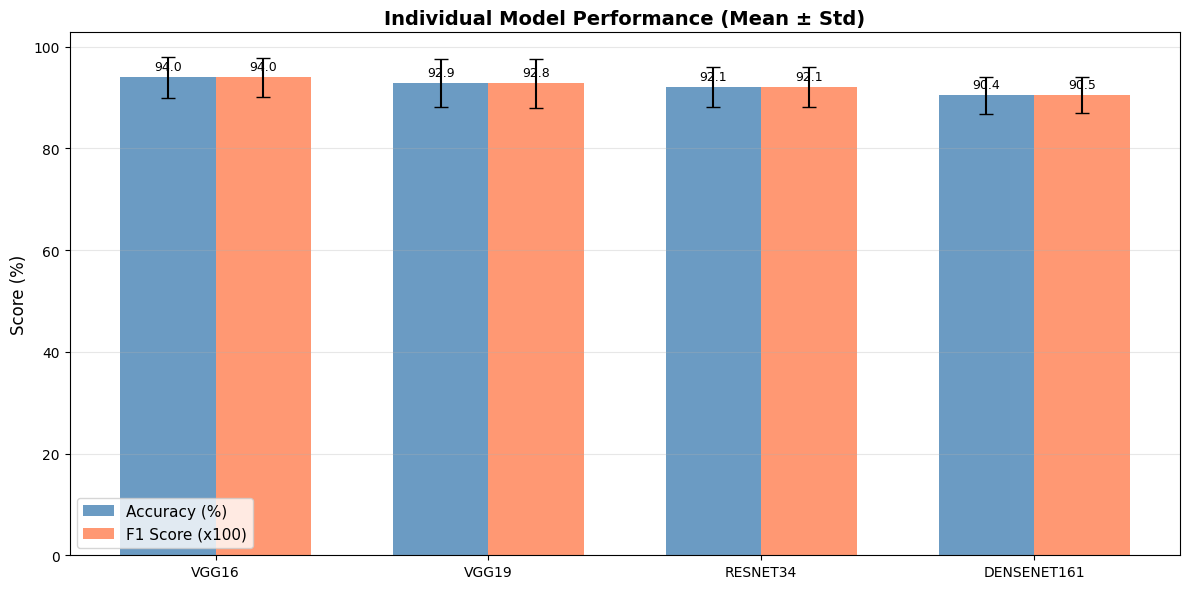

In [23]:
# Bar plot with error bars
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(model_names))
width = 0.35

mean_accs = [np.mean([r['best_val_acc'] for r in all_results[m]]) for m in model_names]
std_accs = [np.std([r['best_val_acc'] for r in all_results[m]]) for m in model_names]

mean_f1s = [np.mean([r['f1_score'] for r in all_results[m]]) * 100 for m in model_names]  # Scale to %
std_f1s = [np.std([r['f1_score'] for r in all_results[m]]) * 100 for m in model_names]

rects1 = ax.bar(x - width/2, mean_accs, width, yerr=std_accs, label='Accuracy (%)', 
                capsize=5, alpha=0.8, color='steelblue')
rects2 = ax.bar(x + width/2, mean_f1s, width, yerr=std_f1s, label='F1 Score (x100)', 
                capsize=5, alpha=0.8, color='coral')

ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Individual Model Performance (Mean ± Std)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in model_names])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'model_comparison_barplot.png'), dpi=150, bbox_inches='tight')
plt.show()

## 10. Confusion Matrices for Each Model

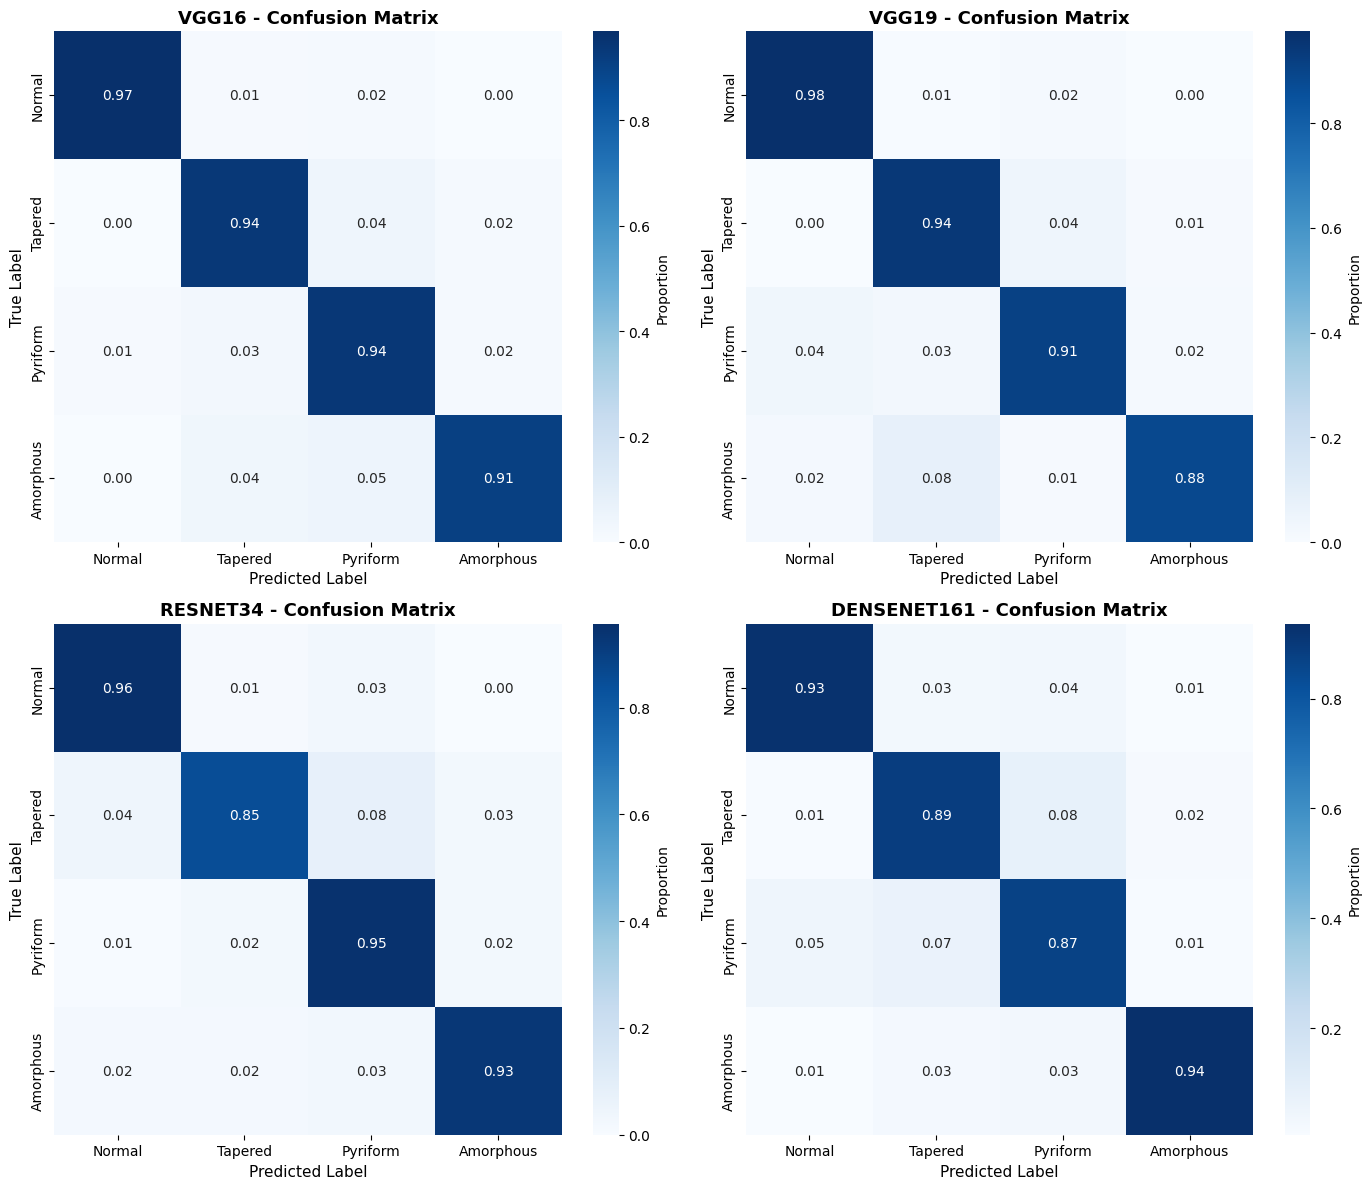

In [24]:
# Aggregate confusion matrices across all folds
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    # Aggregate all predictions
    all_preds = []
    all_true = []
    
    for result in all_results[model_name]:
        all_preds.extend(result['predictions'])
        all_true.extend(result['true_labels'])
    
    # Compute confusion matrix
    cm = confusion_matrix(all_true, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, 
                ax=axes[idx], cbar_kws={'label': 'Proportion'})
    axes[idx].set_title(f'{model_name.upper()} - Confusion Matrix', fontsize=13, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrices.png'), dpi=150, bbox_inches='tight')
plt.show()

## 11. Training History Visualization

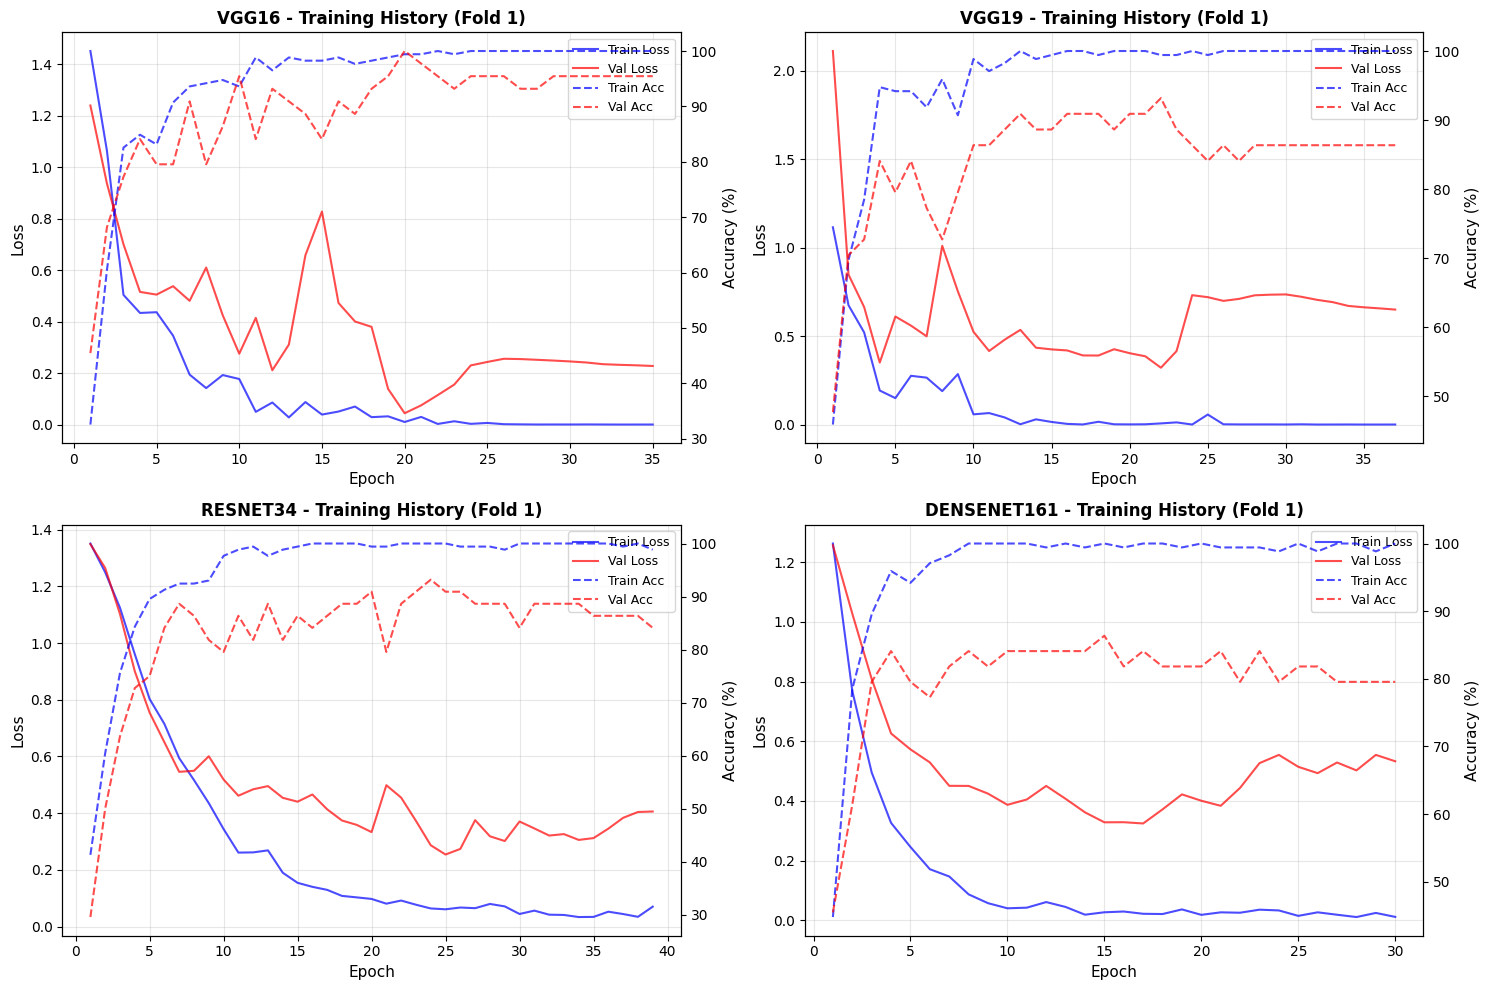

In [25]:
# Plot training history for one fold of each model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, model_name in enumerate(model_names):
    # Get first fold history as example
    history = all_results[model_name][0]['history']
    
    ax = axes[idx]
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax2 = ax.twinx()
    
    # Plot loss
    l1 = ax.plot(epochs, history['train_loss'], 'b-', label='Train Loss', alpha=0.7)
    l2 = ax.plot(epochs, history['val_loss'], 'r-', label='Val Loss', alpha=0.7)
    
    # Plot accuracy
    l3 = ax2.plot(epochs, history['train_acc'], 'b--', label='Train Acc', alpha=0.7)
    l4 = ax2.plot(epochs, history['val_acc'], 'r--', label='Val Acc', alpha=0.7)
    
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('Loss', fontsize=11, color='black')
    ax2.set_ylabel('Accuracy (%)', fontsize=11, color='black')
    ax.set_title(f'{model_name.upper()} - Training History (Fold 1)', fontsize=12, fontweight='bold')
    
    # Combine legends
    lns = l1 + l2 + l3 + l4
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc='upper right', fontsize=9)
    
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

## 12. Save Models

In [26]:
# Save best model from each architecture (best fold)
models_dir = os.path.join(OUTPUT_DIR, 'saved_models')
os.makedirs(models_dir, exist_ok=True)

for model_name in model_names:
    # Find best fold
    results_list = all_results[model_name]
    best_idx = np.argmax([r['best_val_acc'] for r in results_list])
    best_result = results_list[best_idx]
    
    # Save model
    save_path = os.path.join(models_dir, f'{model_name}_best.pth')
    torch.save({
        'model_name': model_name,
        'model_state_dict': best_result['model_state'],
        'accuracy': best_result['best_val_acc'],
        'f1_score': best_result['f1_score'],
        'repeat': best_result['repeat'],
        'fold': best_result['fold']
    }, save_path)
    
    print(f"{model_name.upper()}: Saved best model (Repeat {best_result['repeat']}, Fold {best_result['fold']})")
    print(f"  Accuracy: {best_result['best_val_acc']:.2f}% | F1: {best_result['f1_score']:.4f}")
    print(f"  Path: {save_path}\n")

VGG16: Saved best model (Repeat 1, Fold 1)
  Accuracy: 100.00% | F1: 1.0000
  Path: /home/23giang.ns/ML_Project/HuSHem/outputs/saved_models/vgg16_best.pth

VGG19: Saved best model (Repeat 1, Fold 3)
  Accuracy: 100.00% | F1: 1.0000
  Path: /home/23giang.ns/ML_Project/HuSHem/outputs/saved_models/vgg19_best.pth

RESNET34: Saved best model (Repeat 1, Fold 3)
  Accuracy: 100.00% | F1: 1.0000
  Path: /home/23giang.ns/ML_Project/HuSHem/outputs/saved_models/resnet34_best.pth

VGG19: Saved best model (Repeat 1, Fold 3)
  Accuracy: 100.00% | F1: 1.0000
  Path: /home/23giang.ns/ML_Project/HuSHem/outputs/saved_models/vgg19_best.pth

RESNET34: Saved best model (Repeat 1, Fold 3)
  Accuracy: 100.00% | F1: 1.0000
  Path: /home/23giang.ns/ML_Project/HuSHem/outputs/saved_models/resnet34_best.pth

DENSENET161: Saved best model (Repeat 3, Fold 1)
  Accuracy: 95.45% | F1: 0.9554
  Path: /home/23giang.ns/ML_Project/HuSHem/outputs/saved_models/densenet161_best.pth

DENSENET161: Saved best model (Repeat 3, 

## 13. Detailed Classification Reports

In [27]:
# Generate classification reports
for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"{model_name.upper()} - Classification Report (All Folds Aggregated)")
    print(f"{'='*80}")
    
    # Aggregate predictions
    all_preds = []
    all_true = []
    
    for result in all_results[model_name]:
        all_preds.extend(result['predictions'])
        all_true.extend(result['true_labels'])
    
    # Generate report
    report = classification_report(all_true, all_preds, target_names=CLASS_NAMES, digits=4)
    print(report)
    
    # Save to file
    with open(os.path.join(OUTPUT_DIR, f'{model_name}_classification_report.txt'), 'w') as f:
        f.write(report)


VGG16 - Classification Report (All Folds Aggregated)
              precision    recall  f1-score   support

      Normal     0.9874    0.9691    0.9782       162
     Tapered     0.9198    0.9371    0.9283       159
    Pyriform     0.8994    0.9415    0.9200       171
   Amorphous     0.9595    0.9103    0.9342       156

    accuracy                         0.9398       648
   macro avg     0.9415    0.9395    0.9402       648
weighted avg     0.9409    0.9398    0.9400       648


VGG19 - Classification Report (All Folds Aggregated)
              precision    recall  f1-score   support

      Normal     0.9405    0.9753    0.9576       162
     Tapered     0.8876    0.9434    0.9146       159
    Pyriform     0.9286    0.9123    0.9204       171
   Amorphous     0.9650    0.8846    0.9231       156

    accuracy                         0.9290       648
   macro avg     0.9304    0.9289    0.9289       648
weighted avg     0.9303    0.9290    0.9289       648


RESNET34 - Classifica

## 14. Save Complete Results

In [28]:
# Save detailed results to pickle for ensemble model
import pickle

results_path = os.path.join(OUTPUT_DIR, 'individual_models_results.pkl')
with open(results_path, 'wb') as f:
    pickle.dump(all_results, f)

print(f"All results saved to: {results_path}")
print("\nYou can load these results for ensemble model training.")

All results saved to: /home/23giang.ns/ML_Project/HuSHem/outputs/individual_models_results.pkl

You can load these results for ensemble model training.


## Summary

This notebook trained 4 individual CNN models (VGG16, VGG19, ResNet-34, DenseNet-161) using:
- **Transfer Learning** from ImageNet
- **3x Repeated 5-Fold Cross-Validation**
- **Weighted Random Sampling** for class imbalance
- **Data Augmentation** (vertical flipping only)
- **Early Stopping** with patience

The results are saved and ready for the next step: **Ensemble Model Training**.

Proceed to `02_train_ensemble_model.ipynb` to create the stacked ensemble classifier.